# Lab2 Twitter Data Crawling (Network Crawling)
## Due: Midnight, September 25th
In Lab 1, we have introduced the process of crawling users' friend ID list and follower ID list. <br> 
In this lab, we will apply what we have learned in lab 1 for Twitter network crawling. We will:
1. **Crawl user network with Breadth-First-Search.**
2. **Know the rate limit in Twitter and estimation of crawling time.**
3. **Save the graph in a sutiable structure.**
4. **Learn simple graph visualization with NetworkX.**

## Save Your Notebook! 
- Click on File (upper left corner), Select “Save” or press Ctrl+S.
- Important: You may loose your modification to a notebook if you do not Save it explicitly.
- Advice: Save often.  


## Submission
- Please follow the instructions and finish the exercises.
- After you finish the lab, please Click on File, Select “Download .ipynb”
- After download is complete, Click on File, Select “Print”, and and Choose ``Save as PDF''
- Submit both the Notebook file and the PDF File as your submission for Lab 2.

# 1. Preparation
Before we start to use the tweepy to collect information from Twitter, we have some required preparations for environment and authentication credentials.


# 1.1 Connect this Colab notebook with your Google Drive

In [2]:
# The following code will mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Set the folder `My Drive/DS420` in the google drive as the working directory**

In [3]:
cd /content/gdrive/MyDrive/DS420

/content/gdrive/MyDrive/DS420


# 1.2. Install Tweepy and NetworkX
We will use Tweepy to crawl twitter network and use NetworkX for visualizing the network. NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. For more details, please refer to: https://networkx.github.io/

Tweepy and NetworkX should have been installed in Colab. If not, please run the following codes to install them.

In [4]:
!pip install tweepy
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1.3. Build API Object
As we did in lab 1, we need to finish the authentication and build an api oject for Twitter network information crawling.

In [5]:
import tweepy

# replace with your own tokens
CONSUMER_KEY = "1LkEYBpu8nd7cjAwEgfR99coQ"
CONSUMER_SECRET = "YxuZldd2DD8k7pV00SXVLsagVOdv9Lbq6Es71bQG07tKkhkEyE"
ACCESS_TOKEN = "1565395897592287233-G6F4BNJqd0wVyT7mIg9FHkW1h2EWQa"
ACCESS_TOKEN_SECRET = "hGJD9kbLSbGWtkYriUq5vgRgVmWlwQAnKd7zIdC0KG3ui"


# Authenticate to Twitter
auth = tweepy.OAuthHandler(consumer_key=CONSUMER_KEY, consumer_secret=CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN,ACCESS_TOKEN_SECRET)

# build a api object, set the flag wait no rate limit to True
api = tweepy.API(auth,retry_count=5,retry_delay=1, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

if api.verify_credentials():
    print("Authentication OK")
else:
    print("Error during authentication")

Authentication OK


# 2. Network Crawling
## 2.1 Rate limit
Twitter API has rate limit, i.e., the amount of queries we can make per time window per access token. We will introduce the basics of rate limit. For more details, pleare refer to these two links: [Rate limits](https://developer.twitter.com/en/docs/basics/rate-limits) and [Rate limiting](https://developer.twitter.com/en/docs/basics/rate-limiting)


### Per user
Rate limiting of the standard API is primarily on a per-user basis — or more accurately described, per user access token. If a method allows for 15 requests per rate limit window, then it allows 15 requests per window per access token. If we exceed the rate limit, Twitter API will return “rate limit exceeded” message and Twitter will not provide any updates until the next time window.


### 15 minute windows
Rate limits are divided into 15 minute intervals


### Some frequently used API's rate limits
More could be found in [Rate limits](https://developer.twitter.com/en/docs/basics/rate-limits).

| Request  | Requests/15 minutes window |
| ------------- | ------------- |
| GET /followers/ids  | 15 |
| GET /friends/ids  | 15  |
| GET /status/look_up <br>(get tweets with tweet ids)| 900 |
| GET /users/look_up <br> (get user profiles with user ids)| 900 |
| GET /status/user_timeline | 900 |

### Call rate_limit_status:
With rate_limit_status function, you can get the rate limit status of your own app in json format

In [6]:
# with rate_limit_status, you can get the rate limit status of your own app in json format. We use pprint to print out the status.
import pprint
rate_limit_status = api.rate_limit_status()
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(rate_limit_status)

{   'rate_limit_context': {   'access_token': '1565395897592287233-G6F4BNJqd0wVyT7mIg9FHkW1h2EWQa'},
    'resources': {   'account': {   '/account/authenticate_web_view': {   'limit': 50,
                                                                          'remaining': 50,
                                                                          'reset': 1663907142},
                                    '/account/change_password': {   'limit': 15,
                                                                    'remaining': 15,
                                                                    'reset': 1663907142},
                                    '/account/login_verification_enrollment': {   'limit': 15,
                                                                                  'remaining': 15,
                                                                                  'reset': 1663907142},
                                    '/account/personalization/p13n_pref

In [7]:
# print the rate limit status about crawling follwers ids
limit_follower_ids = rate_limit_status['resources']['followers']['/followers/ids']
print("/followers/ids limit: {}, remaining: {}".format(limit_follower_ids["limit"],limit_follower_ids["remaining"]))


/followers/ids limit: 15, remaining: 15


## <font color='green'>Exercise 1</font>
Read the format of rate_limit_status and follow the example in the above cell, get and print the rate limit status of /friends/ids

In [8]:
# TO DO
limit_friends_ids = rate_limit_status['resources']['friends']['/friends/ids']
print("/friends/ids limit: {}, remaining: {}".format(limit_friends_ids["limit"],limit_friends_ids["remaining"]))

/friends/ids limit: 15, remaining: 15


## 2.2 Crawl Twitter Network
As mentioned, we will apply a breath-first-search method to crawl Twitter network. <br>
The network will be stored in a dictionary (like the adjacency list) where:
* The key is the user ID
* The values is a set of friends user IDs 

##  2.2.1 The process of breadth-first-search
Here we implement two versions for the breadth first search.
1. The first one is implemented with recursive functhion. Everything is stored in the network object in memory. This method is easy to implement. **However, as all information are stored in the network including all the friends ids of the users, as a result, if the network is really large, there will be a memeory issue.**
2. We could use a queue to implement the BFS. And the friends ids of a user could be saved in a single file. In this way we are not required to store all the information in the memory. More specially, it will store the network in this way:
 * save_file:
     * <user_id>.json: a json file containing the user id and all the friend ids of the user 
     * ......
     
### Dealing with rate limit
As we know, the rate limit for crawling friends is 15/window. Thus, we could easily hit the rate limit, which requires to wait another 15 minutes.
1. In tweepy, if we set the wait_on_rate_limit flag ture as section 1.2 did : <br>
`api = tweepy.API(auth,retry_count=5,retry_delay=1, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)`, <br>
It will automaticaly wait for 15 minutes. 
2. In Colab, the wait_on_rate_limit function is not so stable which may be caused by the connection problem.<br>
Therefore, we also implement the waiting mechanism by ourselves in the Second version BFS. 
3. Since the rate limit is per access token, to **shorten the waiting time**, we can create multiple apps with on Twitter developer account. We can alternate between these access tokens, i..e, when one access token exceeds rate limit, we use another access token. We implement this in the 2nd version of BFS.

## $1^{st}$ version BFS function, recursive:

In [9]:
# The function to crawl the users' friends 
def BFS(user_id, network, current_depth=0, max_depth=1):
    """
    :param user_id: the seed id we want to start with
    :param network: the dictionary we want to store the network
    :param current_depth: record the current depth 
    :param max_depth: the number of hops we want to creal start from the seed id
    :return: 
    """
    if(current_depth > max_depth):
        return 
    
    # crawl the friends of the user
    friends_id_list = set()
    for friends_id in tweepy.Cursor(api.friends_ids,user_id=user_id,count=5000).items():
        friends_id_list.add(friends_id)
    network[user_id] = friends_id_list
    print("In depth: {}, {} friends ids are crawled".format(current_depth,len(friends_id_list)))
    
    depth = current_depth+1
    for friends_id in friends_id_list:
        BFS(friends_id,network,depth,max_depth)


## $2^{nd}$ version BFS function, queue:
This is the version we discussed in class. We will use a queue to store the ids we want to visit. As Twitter API has rate limit (15 per window per access tokens for user freind ids), we will use multiple access tokesn to accelerate the speed. 
### Preparation: Create Multiple Apps
In Lab 1, you have created one app and get the credentials for the app. Each Twitter deveoper account allows us to create multiple apps. Now
- create 3 apps
- store the key and tokesn in a text file named "tokens_list.txt"
- if you are using Mac, make sure that the file is txt file 

In the file, each line is the credentials for one app. For example, if you have three apps, it will be <br>

CONSUMER_KEY1 CONSUMER_SECRET1 ACCESS_TOKEN1 ACCESS_TOKEN_SECRET1<br>
CONSUMER_KEY2 CONSUMER_SECRET2 ACCESS_TOKEN2 ACCESS_TOKEN_SECRET2<br>
CONSUMER_KEY3 CONSUMER_SECRET3 ACCESS_TOKEN3 ACCESS_TOKEN_SECRET3

Note that in each line, the key, secret, token and token secret are seperate by whitespace.


## <font color='green'>Exercise 2</font>
Follow the above description, create multiple apps and save their credentials in a file named "tokens_list.txt". Upload yhe file to `My Drive/DS420` folder of your google drive as shown below:

<img src="https://drive.google.com/uc?export=view&id=1FK93QzL7ZUsjDRZUvCY0e-hKO3vnM55X" width="380" align="center"/>


### Create multiple api objects

In [10]:
def tweepy_authentication(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET):
    # Authenticate to Twitter
    auth = tweepy.OAuthHandler(consumer_key=CONSUMER_KEY, consumer_secret=CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

    # build a api object, set the flag wait no rate limit to True
    api = tweepy.API(auth, retry_count=5, retry_delay=1, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    if api.verify_credentials():
        print("Authentication OK")
    else:
        print("Error during authentication")

    return api

In [11]:
# authenticate multiple apis, which are stored in api_list
token_list_path = "/content/gdrive/My Drive/DS420/tokens_list.txt"
f = open(token_list_path)
api_list = [] # the api objects are stored in api_list
for line in f:
    CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET = line.strip().split(' ')
    api_list.append(tweepy_authentication(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET))

Authentication OK
Authentication OK
Authentication OK


In [12]:
import os
import json
import time

def BFS_queue(user_id, save_path, api_list, max_depth, threshold=5000):
    """
    :param user_id: the seed user id we want to start with
    :param save_path: for each user, we will save the user's friendlist
    :param api_list: an array of api objects
    :param max_depth: the maximual depth we want to use to crawl the network
    :param threshold: the maximual number of freinds we want to get for each user
    :return: 
    """
    queue = []
    queue.append((user_id, 0))
    current_depth = 0

    if (not os.path.exists(save_path)):
        os.makedirs(save_path)

    limit_friends_number_list = []
    for api in api_list:
        rate_limit_status = api.rate_limit_status()
        limit_friends_number_list.append(rate_limit_status['resources']['friends']['/friends/ids']["remaining"])

    rate_limit_exceeded = False

    node_number = 0
    while (len(queue) > 0):
        head_user_id, current_depth = queue.pop()

        if (current_depth > max_depth):
            break

        friends_id_list = []
        
        # check whether reach the rate limit
        rate_limit_exceeded = True
        for i in range(0, len(api_list)):
            if limit_friends_number_list[i] > 0:
                rate_limit_exceeded = False
                break
        current_api_id = i
        if rate_limit_exceeded:
            print("Rate limit reached, we need to sleep 900 s (from DS420)")
            time.sleep(910)
            # after sleep, reset to 15
            for k in range(0, len(api_list)):
                limit_friends_number_list[k] = 15
                rate_limit_exceeded = False
                current_api_id = 0

        # start crawling
        api = api_list[current_api_id]

        indicator = 0
        for friends_id in tweepy.Cursor(api.friends_ids, user_id=head_user_id, count=5000).pages():
            indicator += 1
            friends_id_list.extend(friends_id)
            limit_friends_number_list[current_api_id] -= 1

            if len(friends_id_list) > threshold-1:
                break
            
            # check whether reach the rate limit
            if len(friends_id)==5000 and limit_friends_number_list[current_api_id] <= 0:
                print("Rate limit reached, we need to sleep 900 s (from DS420)")
                time.sleep(910)
                # after sleep, reset to 15
                for k in range(0, len(api_list)):
                    limit_friends_number_list[k] = 15
                    rate_limit_exceeded = False
                    current_api_id = 0
                api = api_list[current_api_id]
        if indicator==0 :
            limit_friends_number_list[current_api_id] -= 1

        friends_id_dict = {"user_id": head_user_id, "friends_id": friends_id_list}

        # save to file
        with open(os.path.join(save_path, "{}.json".format(head_user_id)), 'w') as f:
            json.dump(friends_id_dict, f)

        print("======{} Node Crawled=======".format(node_number))
        print("In depth: {}, {} friends ids are crawled".format(current_depth, len(friends_id_list)))
        node_number += 1
        
        if current_depth == 0 :
          print("we are going to crawl {} friends in first depth".format(len(friends_id_list)))

        if (current_depth < max_depth):
            queue.extend([(friends_id, current_depth + 1) for friends_id in friends_id_list])

## 2.2.2 Post process
After we apply the BFS function, we get a dictionary that the key is the user and the value is a set that containing all the friend ids the user. Some of the friend ids (those at the max_depth) contains user ids beyond the key set. Sometimes, we may also want to convert the network to be undirected. The following example could better explain the required post process.

| key | ids |
| ------------- | ------------- |
| 1 | 2,3|
| 2 | 3,100|
| 3 | 2 |
| 4 | 2 |
After the post process, the dictionary should be:

| key | ids |
| ------------- | ------------- |
| 1 | 2,3|
| 2 | 1,3,4|
| 3 | 1,2|
| 4 | 2|



## Post process for the first version of BFS

In [13]:
def post_process(network, convert_to_undirected=True):
    # confrim the nodes of the network
    user_ids = set(network.keys())
    
    # eliminate the stored friends ids that are not covered in the nodes users ids of the network
    for user,friends in network.items():
        friends = user_ids&friends
        network[user] = friends    
        
    # convert to undirected
    if convert_to_undirected:
        for user,friends in network.items():
            for friend in friends:
                network[friend].add(user)
        for user,friends in network.items():
            network[user] = list(friends)
    return network

## Post process for the second version of BFS

In [14]:
def post_process_2(save_path, convert_to_undirected=True):
    network = dict()
    file_names = os.listdir(save_path)
    user_ids = set()
    
    # confrim the nodes of the network
    for name in file_names:
        user_id = int(name.replace(".json",""))
        user_ids.add(user_id)
        
    # eliminate the stored friends ids that are not covered in the nodes users ids of the network
    for name in file_names:
        friends_id_dict = json.load(open(os.path.join(save_path,name),"r"))
        
        user_id = friends_id_dict["user_id"]
        friends_id_set = set(friends_id_dict["friends_id"]) & user_ids

        network[user_id] = friends_id_set
        
    # convert to undirected
    if convert_to_undirected:
        for user,friends in network.items():
            for friend in friends:
                network[friend].add(user)

        for user,friends in network.items():
            network[user] = list(friends)
    return network

## 2.2.3 Crawl the network 
Now we want to crawl the network whose nodes are F1LasVegas and friends of F1LasVegas.<br>
More specially, F1LasVegas have 44 twitter friends. And our friend_ids are limited to 15 requests/15 minuts. <br>
Thus, we needs around **(1+44/(15$\times$num_of_apis))$\times$15** minutes to get the friends ids of F1LasVegas and friend ids of the F1LasVegas's twitter freinds. 
<br>
**Note that, if you want to crawl the network of F1LasVegas without waiting, you are required to apply at least 3 apps**
<br>
After we get all the friend ids of the users, we can do the post process.





## First version, recursive:
We just show the code of the first version, but are not going to use the first version for network crawling due to the following reasons:
- We didn't optimize the code with multiple apis. Thus, it is very time consuing to use the first version to crawl the network
- If we run on Colab, sometimes, it may occur **remoteconnection error** or **httperror**. In that case, you will need to try to run the **second version** or **re-run** this cell.
- If we set max_depth to a large number, say 3, then it may run out of memeory.

Thus, we will only use the 2nd version. If you are interested in it. You can uncomment the following code for runing the first version.

In [ ]:
# # Get the user id of F1LasVegas
# screen_name = "F1LasVegas"
# user = api.get_user(screen_name)
# user_id = user.id

In [ ]:
# # build network with breadth-first-search
# network = dict()

# # Since the network only care about F1LasVegas and F1LasVegas's friends, we set the max_depth as 1
# BFS(user_id,current_depth=0,max_depth=1,network=network)

# network = post_process(network)

## Second version, queue:
Due to time limit, we will only crawl one hop network starting from F1LasVegas, i.e., we get the friend list of F1LasVegas, then the friend list of F1LasVegas's friend. You can set max_depth to a larger value to crawl a larger network. 
<br>
**Note that at least 3 apps are required to crawl the network of F1LasVegas without waiting**

In [15]:
# Get the user id of F1LasVegas
screen_name = "F1LasVegas"
user = api.get_user(screen_name)
user_id = user.id

# build network with breadth-first-search
network = dict()

# set the save location for the jsons
save_path = "/content/gdrive/My Drive/DS420/results/network_medium"

# clean the network_medium
if os.path.exists(save_path):
    for file in os.listdir(save_path):
        os.remove(os.path.join(save_path, file))
    print("Clean the directory we will collect")

# use queue to do BFS
BFS_queue(user_id=user_id, api_list=api_list, max_depth=1, save_path=save_path)

# post process for the second version
network = post_process_2(save_path=save_path)

======0 Node Crawled=======
In depth: 0, 45 friends ids are crawled
we are going to crawl 45 friends in first depth
======1 Node Crawled=======
In depth: 1, 83 friends ids are crawled
======2 Node Crawled=======
In depth: 1, 34 friends ids are crawled
======3 Node Crawled=======
In depth: 1, 2503 friends ids are crawled
======4 Node Crawled=======
In depth: 1, 769 friends ids are crawled
======5 Node Crawled=======
In depth: 1, 118 friends ids are crawled
======6 Node Crawled=======
In depth: 1, 3127 friends ids are crawled
======7 Node Crawled=======
In depth: 1, 711 friends ids are crawled
======8 Node Crawled=======
In depth: 1, 702 friends ids are crawled
======9 Node Crawled=======
In depth: 1, 501 friends ids are crawled
======10 Node Crawled=======
In depth: 1, 5000 friends ids are crawled
======11 Node Crawled=======
In depth: 1, 536 friends ids are crawled
======12 Node Crawled=======
In depth: 1, 887 friends ids are crawled
======13 Node Crawled=======
In depth: 1, 162 friend

### Now you should see 44 friend list files saved in resuls/network_medium. Each file is named by the user id and contains the friendlist of the user.

## 2.3 Save the network
The dictionary could be saved in a json file as following:

In [16]:
# build a directory to save the file
# /content/drive/My Drive/DS420/ refers to the DS420 folder we have created in the google drive.
directory = "/content/gdrive/My Drive/DS420/results"
if(not os.path.exists(directory)):
    os.mkdir(directory)
    print("{} has been added".format(directory))
else:
    print("{} already existed".format(directory))
    
network_path = os.path.join(directory,"network.json")
with open(network_path,"w") as f:
    json.dump(network,f)
    print("The network has been saved in {}.".format(network_path))

/content/gdrive/My Drive/DS420/results already existed
The network has been saved in /content/gdrive/My Drive/DS420/results/network.json.


## <font color='green'>Exercise 3</font>
Crawl the friends network and save it as section 2.2.3 and 2.3 did. <br> 
Please
1. Estimate the time that you need to spend on crawling the friends network.
2. Following the steps in above cells, build the network of your own friends (The nodes of the network shoud be yourself and your friends. Thus the max_depth in BFS shoud be 1). If your account hasn't followered anyone, you can use some Twitter user you like.
3. Save your network as **your_name_network.json**
**Note** that if you have too many friends which requires a large amount of time to crawl, you may choose to crawl a user with fewer friends (<=45) such as out example account @Ds420U1, @lukamodric10，and @Ieomessiok


In [17]:
# TODO

# Get the user id of F1LasVegas
screen_name = "Ieomessiok"
user = api.get_user(screen_name)
user_id = user.id

# build network with breadth-first-search
network = dict()

# set the save location for the jsons
save_path = "/content/gdrive/My Drive/DS420/results/Ieomessiok_network_medium"

# clean the network_medium
if os.path.exists(save_path):
    for file in os.listdir(save_path):
        os.remove(os.path.join(save_path, file))
    print("Clean the directory we will collect")

# use queue to do BFS
BFS_queue(user_id=user_id, api_list=api_list, max_depth=1, save_path=save_path)

# post process for the second version
network = post_process_2(save_path=save_path)



# build a directory to save the file
# /content/drive/My Drive/DS420/ refers to the DS420 folder we have created in the google drive.
directory = "/content/gdrive/My Drive/DS420/results"
if(not os.path.exists(directory)):
    os.mkdir(directory)
    print("{} has been added".format(directory))
else:
    print("{} already existed".format(directory))
    
network_path = os.path.join(directory,"Ieomessiok_network.json")
with open(network_path,"w") as f:
    json.dump(network,f)
    print("The network has been saved in {}.".format(network_path))



======0 Node Crawled=======
In depth: 0, 7 friends ids are crawled
we are going to crawl 7 friends in first depth
======1 Node Crawled=======
In depth: 1, 110 friends ids are crawled
======2 Node Crawled=======
In depth: 1, 97 friends ids are crawled
======3 Node Crawled=======
In depth: 1, 178 friends ids are crawled
======4 Node Crawled=======
In depth: 1, 349 friends ids are crawled
======5 Node Crawled=======
In depth: 1, 16 friends ids are crawled
======6 Node Crawled=======
In depth: 1, 35 friends ids are crawled
======7 Node Crawled=======
In depth: 1, 152 friends ids are crawled
/content/gdrive/My Drive/DS420/results already existed
The network has been saved in /content/gdrive/My Drive/DS420/results/Ieomessiok_network.json.


## Network visualization
Here we use a networkx package to visualize the crawled network. 

In [18]:
def split2chunks(more_followers_id):
    chunks = []
    for i in range(0,len(more_followers_id),100):
        if(i+100 < len(more_followers_id)):
            chunks.append(more_followers_id[i:i+100])
        else:
            chunks.append(more_followers_id[i:])
    return chunks

In [19]:
# With this function we can get the names of the users in network
def get_names(network):
    user_ids = list(network.keys())
    user_ids_chunks = split2chunks(user_ids)
    user_profiles = []

    for i,chunk in enumerate(user_ids_chunks):
        user_profiles += api.lookup_users(chunk)
        print("{} chunks has been processed".format(i))

    friend_names = dict()
    for profile in user_profiles:
        friend_names[profile.id]=profile.screen_name
        
    print("processed {}, obtain {} names".format(len(network), len(friend_names)))

    return friend_names

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

def network_visualize(network, friend_names):
    # This funciton is used to visualize the network
    figure = plt.figure(figsize=(20,14))

    G = nx.Graph()
    for user_id,friend_ids in network.items():
        for friend_id in friend_ids:
            if user_id in friend_names and friend_id in friend_names:
                G.add_edge(friend_names[user_id],friend_names[friend_id])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, font_size=10, with_labels=False)
    for p in pos:  # raise text positions
        pos[p][1] += 0.07
    nx.draw_networkx_labels(G, pos)
    plt.show()

0 chunks has been processed
processed 46, obtain 46 names


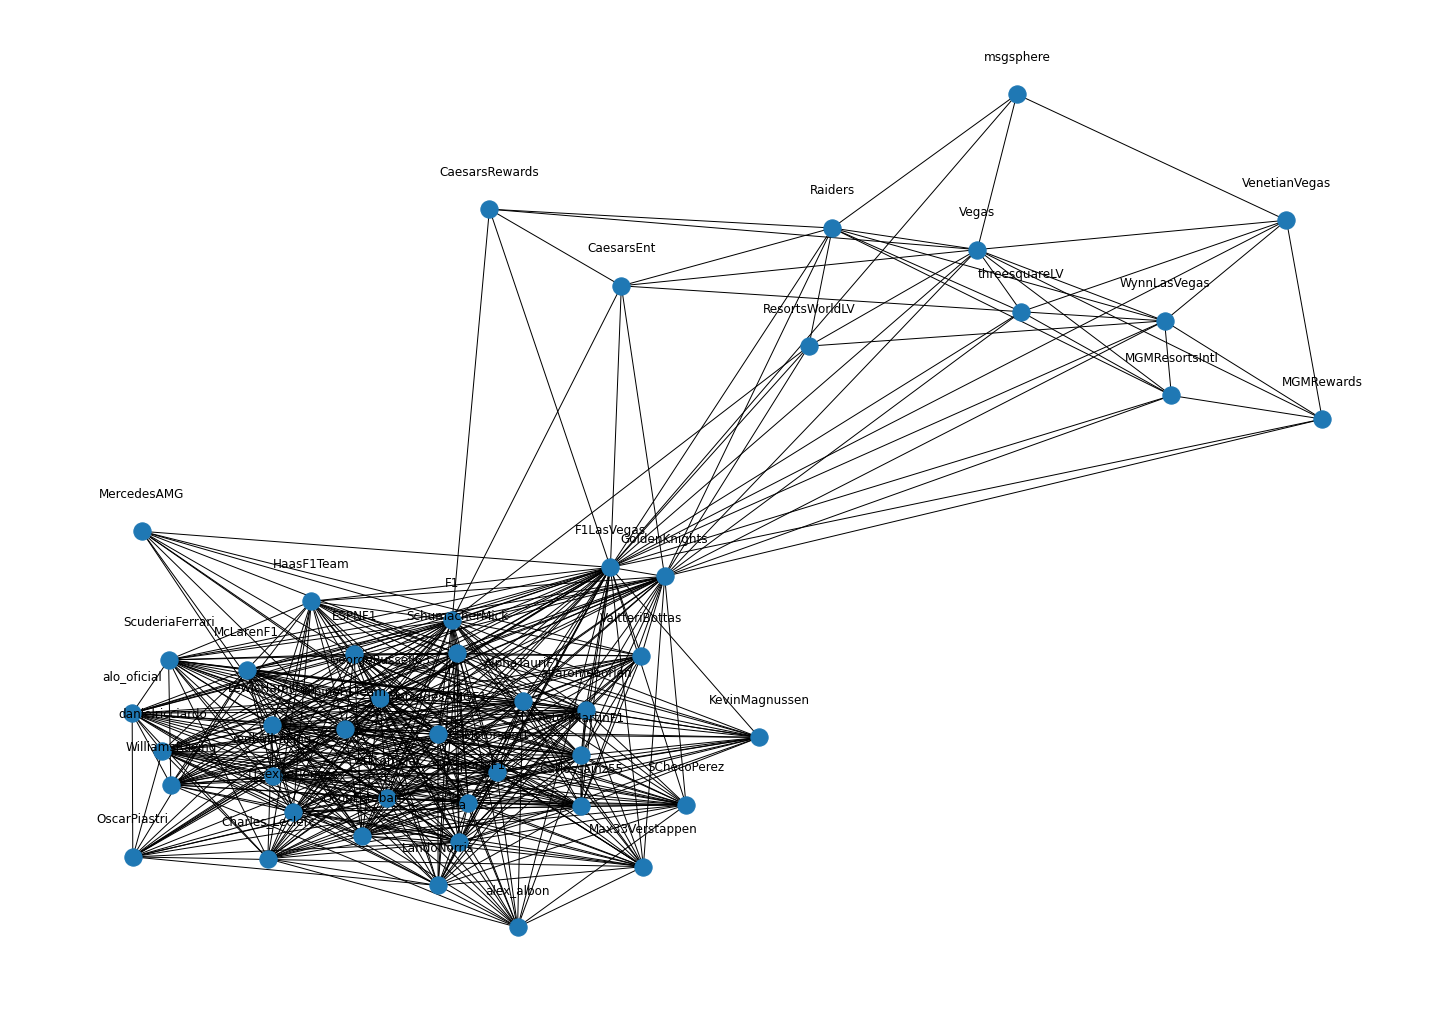

In [21]:
## network visualization

# load the network
network_path = "/content/gdrive/My Drive/DS420/results/network.json"
with open(network_path) as f:
    my_network = json.load(f)
    
# convert string key to int key
mynetwork = dict()
for key in my_network:
    mynetwork[int(key)] = my_network[key]

# 1. get the user names 
friend_names = get_names(mynetwork)

# 2. visualize the network
network_visualize(mynetwork,friend_names)

## <font color='green'>Exercise 4</font>
Visualize the network you have crawled as the above cell did

0 chunks has been processed
processed 8, obtain 8 names


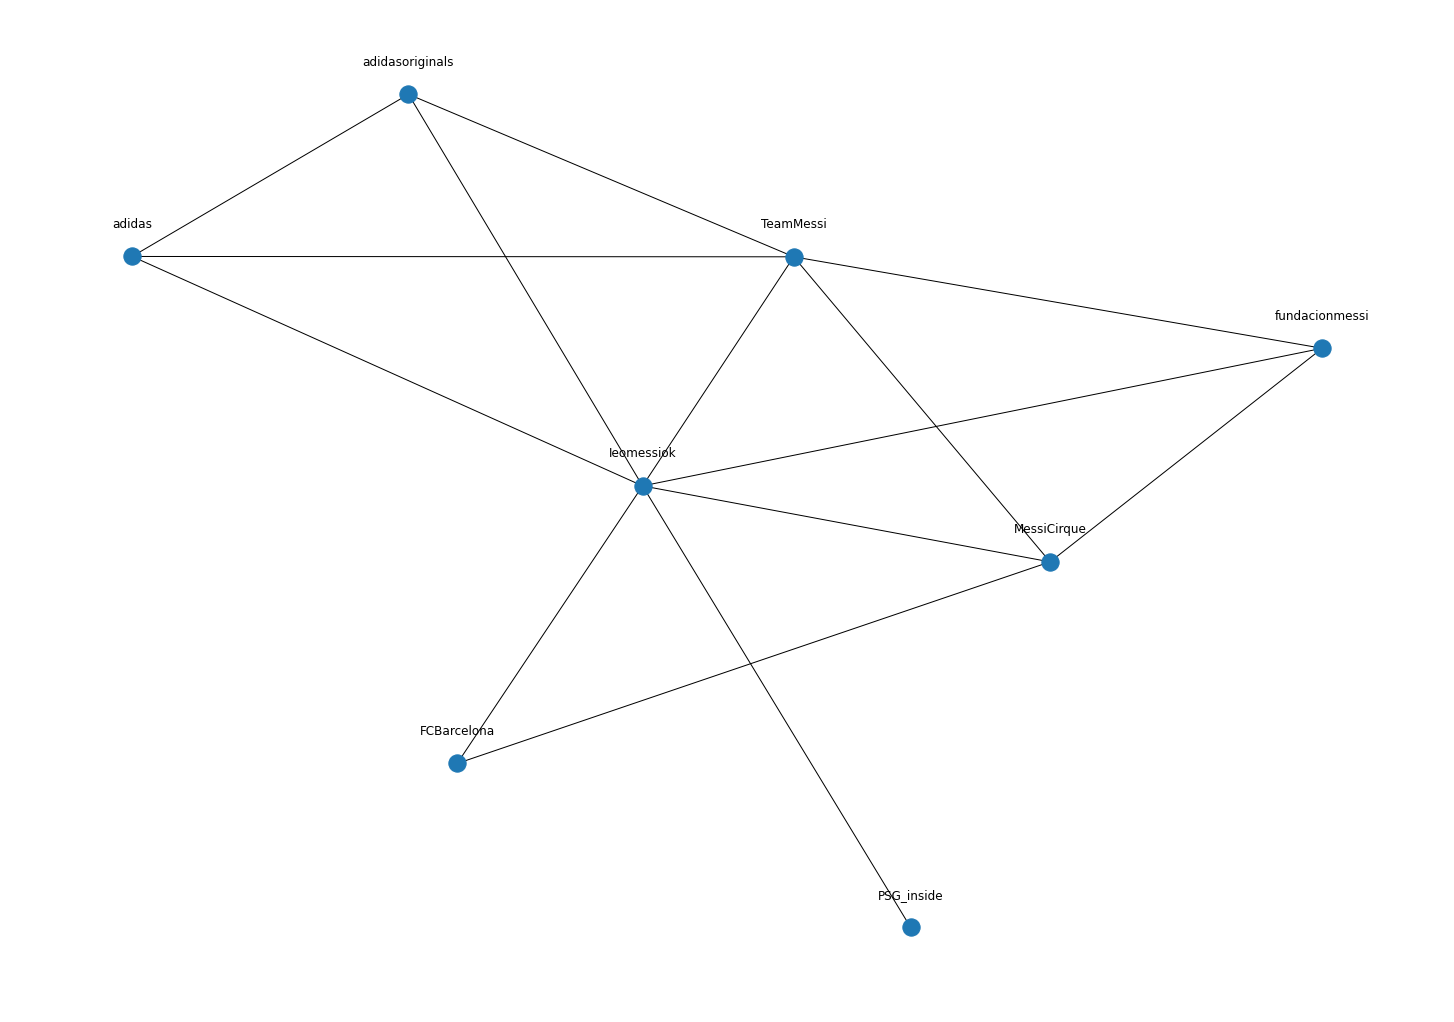

In [22]:
# TO DO
# load the network
network_path = "/content/gdrive/My Drive/DS420/results/Ieomessiok_network.json"
with open(network_path) as f:
    my_network = json.load(f)
    
# convert string key to int key
mynetwork = dict()
for key in my_network:
    mynetwork[int(key)] = my_network[key]

# 1. get the user names 
friend_names = get_names(mynetwork)

# 2. visualize the network
network_visualize(mynetwork,friend_names)